# Recover Actions

In [99]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
from tqdm import tqdm
import pandas as pd
import numpy as np
import arviz as az
import pickle
import math
# Load models
loc = './final objects'

In [141]:
loc = './final objects'
loc_data = '/Users/zachwolpe/Documents/Production/Dynocog/Python Implementation/final instance/data objects/final data objects'

# load data

In [142]:

# bio models -----*
bio_model_top = np.load(loc + '/null_model_top.npz', allow_pickle=True)
bio_model_ran = np.load(loc + '/null_model_ran.npz', allow_pickle=True)

# wcst data -----*
wcst_top100     = pd.read_csv(loc_data + '/df_wcst_top_100.csv')
wcst_ran100     = pd.read_csv(loc_data + '/df_wcst_ran_100.csv')

# psychological covariates -----*
psy_top100     = pd.read_csv(loc_data + '/psy_covars_top100.csv')
psy_ran100     = pd.read_csv(loc_data + '/psy_covars_ran100.csv')

# demographic covariates -----*
dem_top100     = pd.read_csv(loc_data + '/dem_covars_top100.csv')
dem_ran100     = pd.read_csv(loc_data + '/dem_covars_ran100.csv')
# Bayesian Posterior Analysis
# extract data ----------------------------------------*
alpha   = pd.DataFrame.from_records(bio_model_top['arr_0'].tolist()['a'])
beta    = pd.DataFrame.from_records(bio_model_top['arr_0'].tolist()['b'])

a_mu  = bio_model_top['arr_0'].tolist()['a_mu']
b_mu  = bio_model_top['arr_0'].tolist()['b_mu']
a_sd  = bio_model_top['arr_0'].tolist()['a_sd_raw']
b_sd  = bio_model_top['arr_0'].tolist()['b_sd_raw']



def generate_data(bio_mod):
    alpha   = pd.DataFrame.from_records(bio_mod['arr_0'].tolist()['a'])
    beta    = pd.DataFrame.from_records(bio_mod['arr_0'].tolist()['b'])

    a_mu  = bio_mod['arr_0'].tolist()['a_mu']
    b_mu  = bio_mod['arr_0'].tolist()['b_mu']
    a_sd  = bio_mod['arr_0'].tolist()['a_sd_raw']
    b_sd  = bio_mod['arr_0'].tolist()['b_sd_raw']

    return {'alpha': alpha, 'beta': beta, 'a_mu': a_mu, 'b_mu': b_mu, 'a_sd': a_sd, 'b_sd': b_sd}


data = {}
data['top'] = generate_data(bio_model_top)
data['ran'] = generate_data(bio_model_ran)


In [143]:
# extract data ----------------------------------------*
alpha   = pd.DataFrame.from_records(bio_model_top['arr_0'].tolist()['a'])
beta    = pd.DataFrame.from_records(bio_model_top['arr_0'].tolist()['b'])

# first subject params 
a1 = alpha.loc[:,0].mean()
b1 = beta.loc[:,0].mean()

print('alpha: ', a1)
print('beta:  ', b1)

alpha:  0.9688441185927827
beta:   6.1801318205667135


In [144]:
wcst_top100
wcst_ran100.rule.count()

wcst_top100.groupby('rule').count()
wcst_top100.action.value_counts()
wcst_ran100.action.value_counts()

1    4261
3    3047
2    2585
0     107
Name: action, dtype: int64

In [166]:

def generate_Qs_pi(x,a,b):

    # init: [shape, colour, number]
    Qs = np.ones((100,3)) * 0.333

    for i in range(1,100):
        # take action
        at = x.action.values[i]
        rt = x.reward.values[i]

        # update 
        Qs[i, at-1] = Qs[i-1, at-1] + a * (rt - Qs[i-1, at-1])


    # generated predicted actions

    pi = np.ones((100,3)) * 0.333
    pred = []

    for i in range(100):
        
        for j in [0,1,2]:
            pi[i, j] = np.exp(b * Qs[i,j]) / np.exp(b * Qs[i,]).sum()

        # predict
        pred.append(np.random.choice([1,2,3], size=1, p=pi[i,])[0])

    return {'Qs': Qs , 'pi':pi, 'pred':pred}





def plot_data(actions, rewards, Qs):
    plt.figure(figsize=(30,3))
    x = np.arange(len(actions))

    plt.plot(x, Qs[:, 0] - .5 + 0, c='C0', lw=3, alpha=.3)
    plt.plot(x, Qs[:, 1] - .5 + 1, c='C1', lw=3, alpha=.3)
    plt.plot(x, Qs[:, 2] - .5 + 2, c='C2', lw=3, alpha=.3)

    s   = 50
    lw  = 2

    # action = 0
    print(actions)
    cond = (actions == 0) & (rewards == 0)
    plt.scatter(x[cond], actions[cond], s=s, c='None', ec='C0', lw=lw)

    cond = (actions == 0) & (rewards == 1)
    plt.scatter(x[cond], actions[cond], s=s, c='C0', ec='C0', lw=lw)

    # action = 1
    cond = (actions == 1) & (rewards == 0)
    plt.scatter(x[cond], actions[cond], s=s, c='None', ec='C1', lw=lw)

    cond = (actions == 1) & (rewards == 1)
    plt.scatter(x[cond], actions[cond], s=s, c='C1', ec='C1', lw=lw)

    # action = 2
    cond = (actions == 2) & (rewards == 0)
    plt.scatter(x[cond], actions[cond], s=s, c='None', ec='C2', lw=lw)

    cond = (actions == 2) & (rewards == 1)
    plt.scatter(x[cond], actions[cond], s=s, c='C2', ec='C2', lw=lw)


    # provide legend 
    plt.scatter(0, 40, c='k', s=s, lw=lw, label='Reward')
    plt.scatter(0, 20, c='w', ec='k', s=s, lw=lw, label='No reward')
    plt.plot([0,1], [20,20], c='k', lw=3, alpha=.3, label='Qvalue (centered)')


    # axes
    plt.yticks([0,1,2], ['colour', 'shape', 'number'])
    plt.ylim(-1, 3)
    plt.ylabel('action: matching rule')
    plt.xlabel('trial')

    # legend
    handles, labels = plt.gca().get_legend_handles_labels()
    order   = (1,2,0)
    handles = [handles[idx] for idx in order]
    labels  = [labels[idx]  for idx in order]

    plt.legend(handles, labels, fontsize=20, loc=(1.01, .27))
    plt.tight_layout()
    return plt



In [167]:
# Select participant


wcst = wcst_top100.copy() # top or ran
# wcst = wcst_ran100.copy() # top or ran

p = 388850.0
p = wcst.participant.sample()


def fit_estimate(wcst, p, plot=False):
    x       = wcst.loc[wcst.participant==p,]
    p_no    = (x.index // 100)[0]

    # recover parameters estimate
    a = alpha.loc[:,p_no].mean()
    b = beta.loc[:,p_no].mean()

    # calculate
    res = generate_Qs_pi(x,a,b)
    pt  = None
    if plot:
        pt  = plot_data(x.action-1, x.reward, res['Qs'])
        # pt  = plot_data(x.action, x.reward, res['Qs'])

    # accuracy
    acc = np.mean(x.action == res['pred'])

    return {'res':res, 'pt':pt, 'acc':acc}

In [168]:
estimate = fit_estimate(wcst, p.values[0])
estimate['acc']

0.79

In [169]:

wcst = wcst_top100.copy()

pred_acc_top = []
for p in wcst.participant.unique():
    estimate = fit_estimate(wcst, p)
    pred_acc_top.append(estimate['acc'])


wcst = wcst_ran100.copy()

pred_acc_ran    = []
reward_mean     = []
for p in wcst.participant.unique():
    estimate = fit_estimate(wcst, p)
    pred_acc_ran.append(estimate['acc'])

    # test: vs
    x = wcst.loc[wcst.participant==p,]
    reward_mean.append(x.reward.mean())

In [170]:



c1 = '#f7cac9'
c2 = '#f7cac9'
c3 = '#dec2cb'
c4 = '#c5b9cd'
c5 = '#abb1cf'
c6 = '#92a8d1'
import seaborn as sns
cls = sns.color_palette("flare", n_colors=3).as_hex()

c = 'steelblue'

fig = go.Figure()
fig.add_trace(go.Box(y=pred_acc_ran, name='random set',
                    marker_color='rgb(9,56,125)',
    line_color='rgb(9,56,125)'
                ))
fig.add_trace(go.Box(y=pred_acc_top, name = 'top set',
                marker_color = cls[2]
                ))


fig.update_layout(height=400, width=550, template='none')
fig.show()

In [171]:
# view best
print('top mean:    ', np.mean(pred_acc_top))
print('top median:  ', np.median(pred_acc_top))
print('---'*10)
print('ran mean:    ', np.mean(pred_acc_ran))
print('ran median:  ', np.median(pred_acc_ran))
print('ran max:     ', np.max(pred_acc_ran))
print('ran min:     ', np.min(pred_acc_ran))

top mean:     0.8087000000000001
top median:   0.81
------------------------------
ran mean:     0.731
ran median:   0.755
ran max:      0.88
ran min:      0.42


In [172]:

# np.mean(r.action==0), np.mean(r.action==1), np.mean(r.action==2), np.mean(r.action==3)

x.reward.value_counts()

1    64
0    36
Name: reward, dtype: int64

participant:  107700.0
Ave score:    0.83
9300    0
9301    2
9302    0
9303    0
9304    0
       ..
9395    2
9396    2
9397    2
9398    2
9399    2
Name: action, Length: 100, dtype: int64


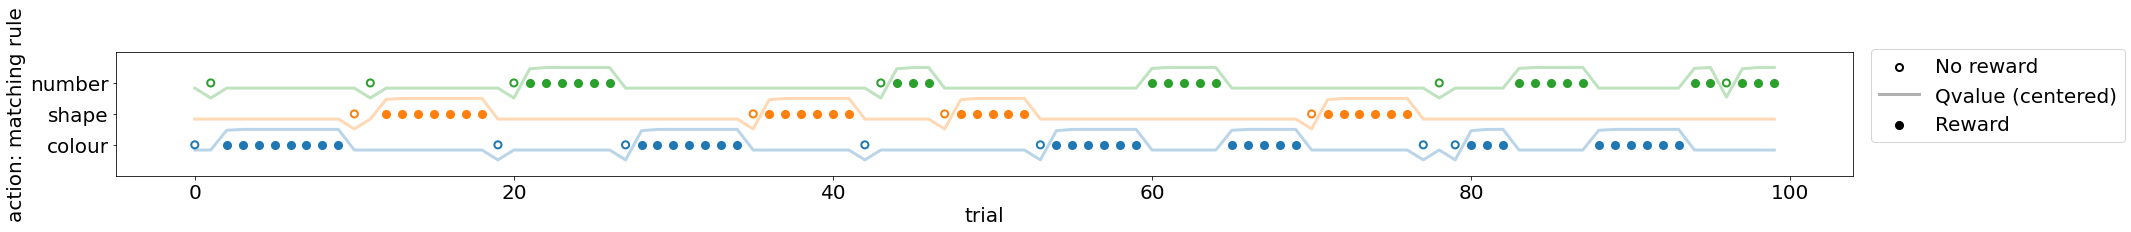

In [177]:
# find max
max_idx = np.where(pred_acc_ran==np.max(pred_acc_ran))[0][0]
p = wcst.participant.unique()[max_idx]
p = np.random.choice(wcst.participant.unique())
print('participant: ', p)
print('Ave score:   ', wcst.loc[wcst.participant==p, ].reward.mean()) # 317920.0

# p = np.random.choice(wcst.participant.unique())
plt.rcParams.update({'font.size': 20})
r = fit_estimate(wcst, p, plot=True)

In [228]:
px.scatter(reward_mean, pred_acc_ran)

0.89

In [45]:

x.action[10]
x.status==1




array([7.83016746, 7.83016746, 7.83016746])

In [28]:
# wcst data 

os.listdir()

# all: pd.read_csv('../model-free analysis/final_dataframes/wcst_raw_data.csv')




,Unnamed: 0,participant,reward,status,action,rule,matching_rule,n_t
0,300,388850.0,0,2,1,shape,shape,0
1,301,388850.0,0,2,3,shape,colour,1
2,302,388850.0,0,2,1,shape,shape,2
3,303,388850.0,1,1,2,shape,number,3
4,304,388850.0,1,1,2,shape,number,4
...,...,...,...,...,...,...,...,...
95,395,388850.0,1,1,2,color,number,95
96,396,388850.0,1,1,2,color,number,96
97,397,388850.0,1,1,2,color,number,97
98,398,388850.0,1,1,2,color,number,98


In [162]:
def plot_data(actions, rewards, Qs):
    plt.figure(figsize=(30,3))
    x = np.arange(len(actions))

    plt.plot(x, Qs[:, 0] - .5 + 0, c='C0', lw=3, alpha=.3)
    plt.plot(x, Qs[:, 1] - .5 + 1, c='C1', lw=3, alpha=.3)
    plt.plot(x, Qs[:, 2] - .5 + 2, c='C2', lw=3, alpha=.3)

    s   = 50
    lw  = 2

    # action = 0
    cond = (actions == 0) & (rewards == 0)
    plt.scatter(x[cond], actions[cond], s=s, c='None', ec='C0', lw=lw)

    cond = (actions == 0) & (rewards == 1)
    plt.scatter(x[cond], actions[cond], s=s, c='C0', ec='C0', lw=lw)

    # action = 1
    cond = (actions == 1) & (rewards == 0)
    plt.scatter(x[cond], actions[cond], s=s, c='None', ec='C1', lw=lw)

    cond = (actions == 1) & (rewards == 1)
    plt.scatter(x[cond], actions[cond], s=s, c='C1', ec='C1', lw=lw)

    # action = 2
    cond = (actions == 2) & (rewards == 0)
    plt.scatter(x[cond], actions[cond], s=s, c='None', ec='C2', lw=lw)

    cond = (actions == 2) & (rewards == 1)
    plt.scatter(x[cond], actions[cond], s=s, c='C2', ec='C2', lw=lw)


    # provide legend 
    plt.scatter(0, 40, c='k', s=s, lw=lw, label='Reward')
    plt.scatter(0, 20, c='w', ec='k', s=s, lw=lw, label='No reward')
    plt.plot([0,1], [20,20], c='k', lw=3, alpha=.3, label='Qvalue (centered)')


    # axes
    plt.yticks([0,1,2], ['colour', 'shape', 'number'])
    plt.ylim(-1, 3)
    plt.ylabel('action: matching rule')
    plt.xlabel('trial')

    # legend
    handles, labels = plt.gca().get_legend_handles_labels()
    order   = (1,2,0)
    handles = [handles[idx] for idx in order]
    labels  = [labels[idx]  for idx in order]

    plt.legend(handles, labels, fontsize=20, loc=(1.01, .27))
    plt.tight_layout()

In [163]:
x

,Unnamed: 0,participant,reward,status,action,rule,matching_rule,n_t
9900,27100,541645.0,1,1,1,shape,shape,0
9901,27101,541645.0,1,1,1,shape,shape,1
9902,27102,541645.0,1,1,1,shape,shape,2
9903,27103,541645.0,1,1,1,shape,shape,3
9904,27104,541645.0,1,1,1,shape,shape,4
...,...,...,...,...,...,...,...,...
9995,27195,541645.0,1,1,3,color,color,95
9996,27196,541645.0,1,1,3,color,color,96
9997,27197,541645.0,1,1,3,color,color,97
9998,27198,541645.0,1,1,3,color,color,98


In [164]:
def data_generating_process(alpha, beta, n=100, p_r=[.8, .6, .7]):
  actions = np.zeros(n, dtype=np.int)
  rewards = np.zeros(n, dtype=np.int)
  Qs      = np.zeros((n, 3))

  # Q init
  Q = np.array(len(p_r)*[1/len(p_r)])

  for i in tqdm(range(n)):
    # P(a|Q): Apply Boltzmann distribution
    exp_Q = np.exp(beta*Q)
    pi_a  = exp_Q / np.sum(exp_Q)


    # Simulate action-reward
    a = np.random.choice([0,1,2], p=pi_a)
    r = np.random.rand() < p_r[a]

    # Update Qt(a) = Qt-1(a) + a[RPE]
    Q[a] = Q[a] + alpha * (r - Q[a])

    # store
    actions[i] = a
    rewards[i] = r
    Qs[i] = Q.copy()

  return actions, rewards, Qs  

In [165]:

x

,Unnamed: 0,participant,reward,status,action,rule,matching_rule,n_t
9900,27100,541645.0,1,1,1,shape,shape,0
9901,27101,541645.0,1,1,1,shape,shape,1
9902,27102,541645.0,1,1,1,shape,shape,2
9903,27103,541645.0,1,1,1,shape,shape,3
9904,27104,541645.0,1,1,1,shape,shape,4
...,...,...,...,...,...,...,...,...
9995,27195,541645.0,1,1,3,color,color,95
9996,27196,541645.0,1,1,3,color,color,96
9997,27197,541645.0,1,1,3,color,color,97
9998,27198,541645.0,1,1,3,color,color,98
